In [44]:
import os, random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [45]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [46]:
class SnakeEnv:
    def __init__(self, width=10, height=10, block_size=20):
        pygame.init()
        self.width, self.height, self.block = width, height, block_size
        # use self.block, not block
        self.display = pygame.Surface((self.width * self.block,
                                       self.height * self.block))
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self.direction = (1, 0)
        self.snake = [(self.width//2, self.height//2)]
        self._place_food()
        self.done, self.score = False, 0
        return self._get_obs()


    def _place_food(self):
        while True:
            self.food = (random.randrange(self.width),
                         random.randrange(self.height))
            if self.food not in self.snake:
                break

    def _get_obs(self):
        head_x, head_y = self.snake[0]
        dir_x, dir_y = self.direction
        food_x, food_y = self.food

        # Danger detection: front, right, left
        def danger_at(offset):
            dx, dy = offset
            new_x, new_y = head_x + dx, head_y + dy
            return int(
                new_x < 0 or new_x >= self.width or
                new_y < 0 or new_y >= self.height or
                (new_x, new_y) in self.snake
            )

        left  = (-dir_y, dir_x)
        right = (dir_y, -dir_x)
        front = (dir_x, dir_y)

        danger = [
            danger_at(front),
            danger_at(right),
            danger_at(left)
        ]

        # Food direction (relative)
        food_dx = int(np.sign(food_x - head_x))
        food_dy = int(np.sign(food_y - head_y))

        # Normalize direction
        dir_features = [
            int(dir_x == 1), int(dir_x == -1),
            int(dir_y == 1), int(dir_y == -1)
        ]

        return np.array(danger + dir_features + [food_dx, food_dy], dtype=np.float32)



    def step(self, action):
        dirs = [(-1,0),(0,1),(1,0),(0,-1)]
        new_dir = dirs[action]
        if (new_dir[0]==-self.direction[0] and
            new_dir[1]==-self.direction[1]):
            new_dir = self.direction
        self.direction = new_dir

        head = (self.snake[0][0]+new_dir[0],
                self.snake[0][1]+new_dir[1])
        if (not 0<=head[0]<self.width or
            not 0<=head[1]<self.height or
            head in self.snake):
            self.done = True
            return self._get_obs(), -10, True, {}

        self.snake.insert(0, head)
        if head == self.food:
            reward, self.score = 10, self.score+1
            self._place_food()
        else:
            reward = -0.1
            self.snake.pop()

        return self._get_obs(), reward, False, {}

    # Inside your SnakeEnv class, overwrite render() with:

    def render(self):
        """
        Return a (H_px, W_px, 3) uint8 image of the game:
         - snake in green, food in red, background black.
        """
        H_px = self.height * self.block
        W_px = self.width  * self.block
        frame = np.zeros((H_px, W_px, 3), dtype=np.uint8)

        # Draw snake
        for x, y in self.snake:
            y0, y1 = y*self.block, (y+1)*self.block
            x0, x1 = x*self.block, (x+1)*self.block
            frame[y0:y1, x0:x1] = np.array([0,255,0], dtype=np.uint8)

        # Draw food
        fx, fy = self.food
        y0, y1 = fy*self.block, (fy+1)*self.block
        x0, x1 = fx*self.block, (fx+1)*self.block
        frame[y0:y1, x0:x1] = np.array([255,0,0], dtype=np.uint8)

        return frame


In [47]:
def save_checkpoint(model, optimizer, path):
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, path)

def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f"Loaded checkpoint from {path}")
    else:
        print("No checkpoint found.")


In [48]:
def plot_rolling_average(rewards, window=50, label="RL", title="Rolling Average Reward"):
    rolling_avg = [np.mean(rewards[max(0, i - window):i+1]) for i in range(len(rewards))]
    plt.figure(figsize=(8, 4))
    plt.plot(rewards, label="Reward")
    plt.plot(rolling_avg, label=f"Rolling Avg ({window})")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [49]:
def evaluate_policy(model, env, mode="dqn", n_episodes=10, max_steps=1000):
    model.eval()
    scores = []
    with torch.no_grad():
        for _ in range(n_episodes):
            state = env.reset()
            total = 0
            done = False
            for _ in range(max_steps):
                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
                if mode == "dqn":
                    q_vals = model(state_tensor)
                    action = q_vals.argmax(dim=1).item()
                else:
                    probs, _ = model(state_tensor)
                    action = probs.argmax(dim=1).item()
                state, reward, done, _ = env.step(action)
                total += reward
                if done:
                    break
            scores.append(total)
    model.train()
    return scores


In [50]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)


In [51]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [62]:
config_dqn = {
    "gamma": 0.99,
    "batch_size": 64,
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 5000,
    "target_update": 10,
    "num_episodes": 1000,
    "ckpt_path": "checkpoints/dqn_snake.pth"
}

ppo_config = {
    "gamma":        0.99,
    "gae_lambda":   0.95,
    "clip_eps":     0.2,
    "lr":           2.5e-4,
    "epochs":       4,
    "batch_size":   64,
    "update_steps": 2048,
    "num_updates":  100  # <--- Add this line
}


config_a2c = {
    "gamma": 0.99,
    "lr": 1e-4,
    "num_episodes": 1000
}




In [53]:
def select_action_dqn(state, eps, model):
    if random.random() < eps:
        return random.randrange(4)
    state_v = torch.from_numpy(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_vals = model(state_v)
    return q_vals.argmax(dim=1).item()

def optimize_dqn_step(memory, policy_net, target_net, optimizer, config):
    if len(memory) < config["batch_size"]:
        return
    transitions = memory.sample(config["batch_size"])
    batch = Transition(*zip(*transitions))

    states      = torch.tensor(batch.state, dtype=torch.float32).to(device)
    actions     = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1).to(device)
    rewards     = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
    dones       = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

    q_values = policy_net(states).gather(1, actions)
    next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q = rewards + config["gamma"] * next_q * (1 - dones)

    loss = F.mse_loss(q_values, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [54]:
def train_dqn(env, policy_net, target_net, memory, optimizer, config):
    episode_rewards = []
    env_steps_list = []
    total_env_steps = 0
    steps_done = 0

    def get_epsilon(step):
        return config["eps_end"] + (config["eps_start"] - config["eps_end"]) * \
               np.exp(-1. * step / config["eps_decay"])

    for ep in range(1, config["num_episodes"] + 1):
        state = env.reset()
        total_reward = 0
        ep_steps = 0

        while True:
            eps = get_epsilon(steps_done)
            action = select_action_dqn(state, eps, policy_net)
            next_state, reward, done, _ = env.step(action)
            memory.push(state, action, reward, next_state, done)
            optimize_dqn_step(memory, policy_net, target_net, optimizer, config)

            state = next_state
            total_reward += reward
            steps_done += 1
            ep_steps += 1

            if done:
                break

        total_env_steps += ep_steps
        env_steps_list.append(total_env_steps)
        episode_rewards.append(total_reward)

        if ep % config["target_update"] == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if ep % 50 == 0:
            print(f"[DQN] Episode {ep} | Avg(50): {np.mean(episode_rewards[-50:]):.2f}")

    return env_steps_list, episode_rewards


In [55]:
class RolloutBuffer:
    def __init__(self):
        self.states, self.actions, self.log_probs = [], [], []
        self.rewards, self.dones, self.values = [], [], []

    def clear(self):
        self.__init__()

def compute_gae(rewards, values, dones, gamma, lam):
    advantages, gae = [], 0
    values = values + [0]
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return advantages


In [56]:
def collect_trajectory(env, model, buffer, steps, max_steps=1000):
    state = env.reset()
    for _ in range(steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, done, _ = env.step(action.item())

        buffer.states.append(state)
        buffer.actions.append(action.item())
        buffer.log_probs.append(dist.log_prob(action).item())
        buffer.rewards.append(reward)
        buffer.dones.append(done)
        buffer.values.append(value.item())

        state = next_state
        if done:
            state = env.reset()


In [57]:
def ppo_update(model, optimizer, buffer, config):
    states = torch.tensor(buffer.states, dtype=torch.float32).to(device)
    actions = torch.tensor(buffer.actions).to(device)
    old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
    rewards, dones, values = buffer.rewards, buffer.dones, buffer.values

    advantages = compute_gae(rewards, values, dones, config["gamma"], config["gae_lambda"])
    returns = torch.tensor([a + v for a, v in zip(advantages, values)], dtype=torch.float32).to(device)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    for _ in range(config["epochs"]):
        for i in range(0, len(states), config["batch_size"]):
            s_batch = states[i:i+config["batch_size"]]
            a_batch = actions[i:i+config["batch_size"]]
            r_batch = returns[i:i+config["batch_size"]]
            adv_batch = advantages[i:i+config["batch_size"]]
            logp_old_batch = old_log_probs[i:i+config["batch_size"]]

            probs, values = model(s_batch)
            dist = torch.distributions.Categorical(probs)
            logp = dist.log_prob(a_batch)
            entropy = dist.entropy().mean()

            ratio = torch.exp(logp - logp_old_batch)
            clipped = torch.clamp(ratio, 1 - config["clip_eps"], 1 + config["clip_eps"]) * adv_batch
            loss_clip = -torch.min(ratio * adv_batch, clipped).mean()
            loss_value = F.mse_loss(values.squeeze(), r_batch)
            loss = loss_clip + 0.5 * loss_value - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [58]:
def train_ppo(env, model, optimizer, config):
    buffer = RolloutBuffer()
    reward_history = []
    env_steps_list = []
    total_env_steps = 0

    for update in range(1, config["num_updates"] + 1):
        collect_trajectory(env, model, buffer, config["update_steps"])
        ppo_update(model, optimizer, buffer, config)
        buffer.clear()

        # PPO collects exactly update_steps env steps per update
        total_env_steps += config["update_steps"]
        eval_scores = evaluate_policy(model, env, mode="ppo", n_episodes=10)
        avg_reward = np.mean(eval_scores)
        reward_history.append(avg_reward)
        env_steps_list.append(total_env_steps)

        print(f"[PPO] Update {update} | Avg Reward: {avg_reward:.2f}")

    return env_steps_list, reward_history


In [59]:
def train_a2c(env, model, optimizer, config):
    rewards = []
    env_steps_list = []
    total_env_steps = 0
    gamma = config["gamma"]
    num_episodes = config["num_episodes"]

    for ep in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False
        ep_steps = 0

        while not done:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            probs, value = model(state_tensor)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, done, _ = env.step(action.item())
            next_state_tensor = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
            _, next_value = model(next_state_tensor)

            target = reward + (1 - done) * gamma * next_value.item()
            advantage = target - value.item()

            policy_loss = -log_prob * advantage
            value_loss = F.mse_loss(value, torch.tensor([[target]], device=device))
            loss = policy_loss + value_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward
            ep_steps += 1

        total_env_steps += ep_steps
        env_steps_list.append(total_env_steps)
        rewards.append(total_reward)

        if ep % 10 == 0:
            print(f"[A2C] Episode {ep} | Avg(10): {np.mean(rewards[-10:]):.2f}")

    return env_steps_list, rewards


In [60]:
print("=== Training DQN ===")
env_dqn = SnakeEnv()
state_dim = len(env_dqn.reset())
action_dim = 4

policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer_dqn = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayMemory(capacity=10000)

dqn_steps, dqn_rewards = train_dqn(env_dqn, policy_net, target_net, memory, optimizer_dqn, config_dqn)


=== Training DQN ===
[DQN] Episode 50 | Avg(50): -9.21
[DQN] Episode 100 | Avg(50): -7.62
[DQN] Episode 150 | Avg(50): -5.07
[DQN] Episode 200 | Avg(50): 5.09
[DQN] Episode 250 | Avg(50): 12.36
[DQN] Episode 300 | Avg(50): 26.75
[DQN] Episode 350 | Avg(50): 44.73
[DQN] Episode 400 | Avg(50): 67.97
[DQN] Episode 450 | Avg(50): 120.53
[DQN] Episode 500 | Avg(50): 145.64
[DQN] Episode 550 | Avg(50): 158.33
[DQN] Episode 600 | Avg(50): 141.26
[DQN] Episode 650 | Avg(50): 151.84
[DQN] Episode 700 | Avg(50): 169.93
[DQN] Episode 750 | Avg(50): 150.06
[DQN] Episode 800 | Avg(50): 149.26
[DQN] Episode 850 | Avg(50): 162.12
[DQN] Episode 900 | Avg(50): 146.89
[DQN] Episode 950 | Avg(50): 131.21
[DQN] Episode 1000 | Avg(50): 135.51


In [63]:
print("=== Training PPO ===")
env_ppo = SnakeEnv()
state_dim = len(env_ppo.reset())
action_dim = 4

ppo_model = ActorCritic(state_dim, action_dim).to(device)
optimizer_ppo = optim.Adam(ppo_model.parameters(), lr=ppo_config["lr"])

ppo_steps, ppo_rewards = train_ppo(env_ppo, ppo_model, optimizer_ppo, ppo_config)


=== Training PPO ===
[PPO] Update 1 | Avg Reward: -10.54
[PPO] Update 2 | Avg Reward: 0.24
[PPO] Update 3 | Avg Reward: 24.96
[PPO] Update 4 | Avg Reward: 60.15
[PPO] Update 5 | Avg Reward: 53.56
[PPO] Update 6 | Avg Reward: 24.85
[PPO] Update 7 | Avg Reward: 47.96
[PPO] Update 8 | Avg Reward: 30.77
[PPO] Update 9 | Avg Reward: 46.37
[PPO] Update 10 | Avg Reward: 65.13
[PPO] Update 11 | Avg Reward: 57.81
[PPO] Update 12 | Avg Reward: 29.02
[PPO] Update 13 | Avg Reward: 54.76
[PPO] Update 14 | Avg Reward: 55.14
[PPO] Update 15 | Avg Reward: 49.20
[PPO] Update 16 | Avg Reward: 47.53
[PPO] Update 17 | Avg Reward: 74.55
[PPO] Update 18 | Avg Reward: 59.59
[PPO] Update 19 | Avg Reward: 71.99
[PPO] Update 20 | Avg Reward: 50.47
[PPO] Update 21 | Avg Reward: 67.99
[PPO] Update 22 | Avg Reward: 43.79
[PPO] Update 23 | Avg Reward: 75.06
[PPO] Update 24 | Avg Reward: 64.79
[PPO] Update 25 | Avg Reward: 55.41
[PPO] Update 26 | Avg Reward: 47.30
[PPO] Update 27 | Avg Reward: 60.66
[PPO] Update 28 

In [66]:
print("=== Training A2C ===")
env_a2c = SnakeEnv()
state_dim = len(env_a2c.reset())
action_dim = 4

a2c_model = ActorCritic(state_dim, action_dim).to(device)
optimizer_a2c = optim.Adam(a2c_model.parameters(), lr=config_a2c["lr"])

a2c_steps, a2c_rewards = train_a2c(env_a2c, a2c_model, optimizer_a2c, config_a2c)


=== Training A2C ===
[A2C] Episode 10 | Avg(10): -10.08
[A2C] Episode 20 | Avg(10): -10.46
[A2C] Episode 30 | Avg(10): -11.35
[A2C] Episode 40 | Avg(10): -9.26
[A2C] Episode 50 | Avg(10): -10.15
[A2C] Episode 60 | Avg(10): -11.39
[A2C] Episode 70 | Avg(10): -9.70
[A2C] Episode 80 | Avg(10): -10.81
[A2C] Episode 90 | Avg(10): -10.01
[A2C] Episode 100 | Avg(10): -11.11
[A2C] Episode 110 | Avg(10): -11.48
[A2C] Episode 120 | Avg(10): -11.58
[A2C] Episode 130 | Avg(10): -11.42
[A2C] Episode 140 | Avg(10): -8.67
[A2C] Episode 150 | Avg(10): -10.34
[A2C] Episode 160 | Avg(10): -10.75
[A2C] Episode 170 | Avg(10): -9.57
[A2C] Episode 180 | Avg(10): -10.32
[A2C] Episode 190 | Avg(10): -8.25
[A2C] Episode 200 | Avg(10): -11.39
[A2C] Episode 210 | Avg(10): -9.22
[A2C] Episode 220 | Avg(10): -8.54
[A2C] Episode 230 | Avg(10): -8.33
[A2C] Episode 240 | Avg(10): -9.67
[A2C] Episode 250 | Avg(10): -10.40
[A2C] Episode 260 | Avg(10): -8.22
[A2C] Episode 270 | Avg(10): -10.40
[A2C] Episode 280 | Avg(10

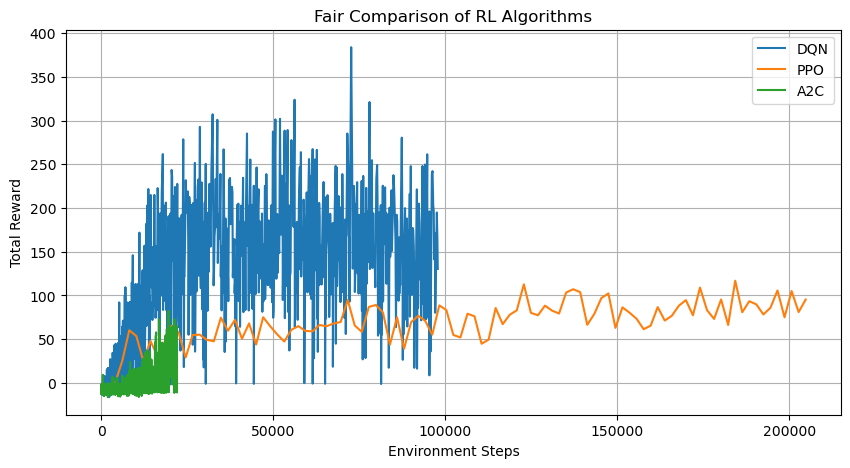

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(dqn_steps, dqn_rewards, label="DQN")
plt.plot(ppo_steps, ppo_rewards, label="PPO")
plt.plot(a2c_steps, a2c_rewards, label="A2C")
plt.xlabel("Environment Steps")
plt.ylabel("Total Reward")
plt.title("Fair Comparison of RL Algorithms")
plt.grid(True)
plt.legend()
plt.show()
